In [0]:
!git clone https://github.com/Miamoto/fruit-classifier

Cloning into 'fruit-classifier'...
remote: Enumerating objects: 14530, done.
remote: Counting objects: 100% (14530/14530), done.
remote: Compressing objects: 100% (14523/14523), done.
remote: Total 14530 (delta 16), reused 14490 (delta 5), pack-reused 0
Receiving objects: 100% (14530/14530), 63.11 MiB | 38.04 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [41]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 23 11:07:57 2019

@author: anama
"""


import os
import keras
import random
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, LeakyReLU
from keras.layers import Dense,Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from IPython.display import display 
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet
from keras import regularizers

train_data_dir = "fruit-classifier/dataset/Training"
test_data_dir = "fruit-classifier/dataset/Test"
weights_filename = "weights.hdf5"


nb_batch_size = 128

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


list_apples = ['Apple Crimson Snow','Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3',
               'Apple Granny Smith', 'Apple Red 1','Apple Red 2', 'Apple Red 3',
               'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2']
list_lemons = ['Lemon', 'Lemon Meyer']
list_pears = ['Pear Abate', 'Pear Kaiser', 'Pear Monster', 'Pear Red','Pear Williams']


def process_images(lst, root_dir):
    res = []
    for obj in lst:
        data_dir = root_dir + '/'+ obj
        for filename in os.listdir(data_dir):
          res.append(data_dir + "/" + filename)
    return res


train_set = []
train_set += process_images(list_apples,train_data_dir)
train_set += process_images(['Orange'], train_data_dir)
train_set += process_images(list_lemons, train_data_dir)
train_set += process_images(list_pears, train_data_dir)
random.shuffle(train_set)

test_set = []
test_set += process_images(list_apples,test_data_dir)
test_set += process_images(['Orange'], test_data_dir)
test_set += process_images(list_lemons, test_data_dir)
test_set += process_images(list_pears, test_data_dir)
random.shuffle(test_set)


train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) 
test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)


# default image size
img_height = 100
img_width = 100


X = [] #images
y = [] #labels
for img_path in train_set:
  X.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR)[:,:,::-1], dsize=(img_height, img_width),
                      interpolation=cv2.INTER_CUBIC)) #read the image
  if 'Apple' in img_path:
    y.append(0)
  elif 'Orange' in img_path:
    y.append(1)
  elif 'Lemon' in img_path:
    y.append(2)
  elif 'Pear' in img_path:
    y.append(3)


X = np.array(X)
y = np.array(y)


from sklearn.model_selection import train_test_split
#30% validation set, 70% training set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)

print("y_train", y_train)
print("Shape of train images is:", X_train.shape)
print("Shape of validation image", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of label", y_val.shape)

num_classes = 4
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

train_generator = train_datagen.flow(X_train, y_train,batch_size=nb_batch_size)
validation_generator = train_datagen.flow(X_val, y_val, batch_size=nb_batch_size)


base_model=MobileNet(weights='imagenet', include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), use_bias=True )(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

#x=LeakyReLU(alpha=0.5)(x)
#x=Dense(32,activation='relu')(x) #dense layer 2
#x=Dense(32,activation='relu')(x) #dense layer 3

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

# set the added layers of the network to be trainable
for layer in base_model.layers:
  layer.trainable = False


nb_layers = len(base_model.layers)
print("nb_layers", nb_layers)

"""
for layer in model.layers[:nb_layers]:
    layer.trainable=False
for layer in model.layers[nb_layers:]:
    layer.trainable=True
"""

y_train [0 3 2 ... 2 0 2]
Shape of train images is: (6555, 100, 100, 3)
Shape of validation image (2810, 100, 100, 3)
Shape of labels is: (6555,)
Shape of label (2810,)


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

'\nfor layer in model.layers[:nb_layers]:\n    layer.trainable=False\nfor layer in model.layers[nb_layers:]:\n    layer.trainable=True\n'

In [0]:
def process_image(file):
    img_path = "MobileNet-inference-images/"
    img = image.load_image(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_expanded)
    
    

In [42]:
import math

y = to_categorical(y)
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(SGD(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

nb_steps_per_epoch = math.floor(X_train.shape[0]/nb_batch_size)
nb_validation_steps = math.floor(X_val.shape[0]/nb_batch_size)
print(nb_steps_per_epoch)
#checkpoint = ModelCheckpoint(weights_filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#history = model.fit_generator(train_generator, steps_per_epoch=4, validation_data = validation_generator, 
#                               validation_steps=2, epochs=50, verbose=2)
history = model.fit(X, y, validation_split=0.3, batch_size=128, epochs=50)

print("fim")

51
Train on 6555 samples, validate on 2810 samples
Epoch 1/50
6555/6555 [==============================] - 13s 2ms/step - loss: 3.4296 - acc: 0.1580 - val_loss: 2.7361 - val_acc: 0.1929
Epoch 2/50
6555/6555 [==============================] - 3s 419us/step - loss: 3.3494 - acc: 0.1632 - val_loss: 2.6722 - val_acc: 0.2039
Epoch 3/50
6555/6555 [==============================] - 3s 414us/step - loss: 3.2723 - acc: 0.1587 - val_loss: 2.6145 - val_acc: 0.2181
Epoch 4/50
6555/6555 [==============================] - 3s 434us/step - loss: 3.1982 - acc: 0.1751 - val_loss: 2.5625 - val_acc: 0.2367
Epoch 5/50
6555/6555 [==============================] - 3s 415us/step - loss: 3.1220 - acc: 0.1812 - val_loss: 2.5165 - val_acc: 0.2612
Epoch 6/50
6555/6555 [==============================] - 3s 417us/step - loss: 3.0452 - acc: 0.1908 - val_loss: 2.4754 - val_acc: 0.2858
Epoch 7/50
6555/6555 [==============================] - 3s 417us/step - loss: 2.9847 - acc: 0.1969 - val_loss: 2.4393 - val_acc: 0.309

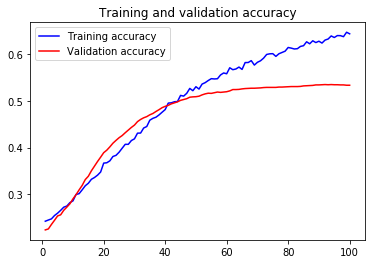

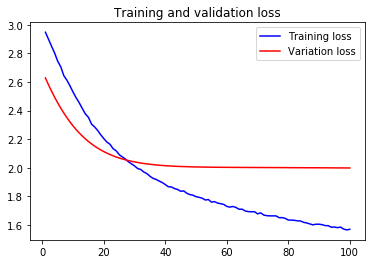

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Variation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
X_test = [] #images
y_test = [] #labels
for img_path in test_set:
  X_test.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR)[:,:,::-1], dsize=(img_height, img_width),
                      interpolation=cv2.INTER_CUBIC)) #read the image
  if 'Apple' in img_path:
    y_test.append(0)
  elif 'Orange' in img_path:
    y_test.append(1)
  elif 'Lemon' in img_path:
    y_test.append(2)
  elif 'Pear' in img_path:
    y_test.append(3)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test = to_categorical(y_test)
print(y_test)

#test_generator = test_datagen.flow(X_test, y_test, batch_size=20)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [0]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

correct_count = 0
for i in range(len(y_pred)):
  index = np.argmax(y_pred[i])
  if y_test[i][index] == 1:
    correct_count += 1
    
print("Accuracy = " + str(correct_count / len(y_pred)))

Accuracy = 0.5248883216336949
